In [1]:
import numpy as np
import matplotlib.pyplot as plt

import math

# Step 1: Generate the data 
I'm aiming to generate 100000 datapoints from a Gaussian mixture model of k = 15 components. For simplicity, each datapoint is a scalar (1-dimension). 


In [2]:
n = 100000 # Number of datapoints
k = 10 # Number of components

# Randomising the weights
weights = np.random.uniform(low = 0.75, high = 1, size=(k, ))
weights = weights / np.sum(weights) 
assert abs(np.sum(weights) - 1) < 0.0000001 # Ensuring a convex linear combination

# Decide which component we will sample from
mixture_index = np.random.choice(k, size = n, replace = True, p = weights)
assert mixture_index.shape == (n, )

# Decide the random mean and variance of all 100 components
mean = np.random.uniform(low=-12.5, high=12.5, size=(k, ))
variance = np.random.uniform(low=0.75, high=2, size=(k, ))


In [3]:
# Generate data using numpy for efficiency
data = np.fromiter((np.random.normal(loc = mean[index], scale = np.sqrt([variance[index]])[0]) for index in mixture_index), float)
assert data.shape == (n, )

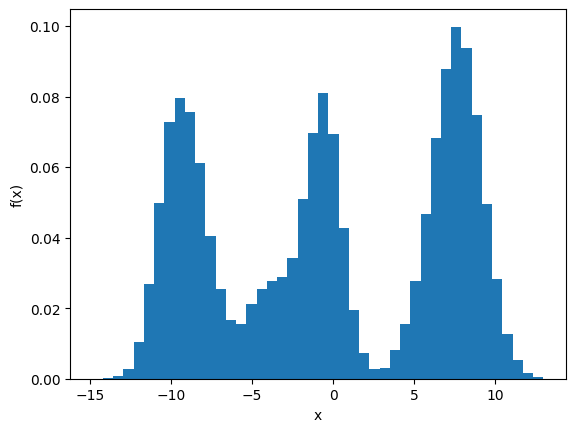

In [4]:
plt.hist(data, bins="auto", density=True)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()

# Step 2: The traditional EM algorithm
The algorithm includes finding the probability of each point belonging to each component, then tune the mean and variance of each component according the the calculated probabilities. 

In [5]:

# First, define a way to calculate pdf 
# This function is actually not used due to its low efficiency. See function calculate_p_matrix below
def pdf(x, input_mean, input_var):
    return math.exp(-0.5 * ((x - input_mean) ** 2 ) / input_var) / (math.sqrt(2 * math.pi * input_var))

# Test the function
assert pdf(0, 0, 1) == 0.3989422804014327
assert pdf(0.5, 0, 1) == 0.3520653267642995


In [6]:
# This p matrix is not yet normalised
def calculate_p_matrix(x, input_mean, input_var, input_weight):
    # Duplicate data so dimensions work out
    mean_matrix = np.tile(input_mean, (len(x), 1)).T
    variance_matrix = np.tile(input_var, (len(x), 1)).T
    weight_matrix = np.tile(input_weight, (len(x), 1)).T
    
    # PDF calculation
    p_matrix = weight_matrix * np.exp(-0.5 * np.power(x - mean_matrix, 2) / variance_matrix) / (np.sqrt(2 * np.pi * variance_matrix))
    
    p_matrix = p_matrix.transpose(1, 0)
    
    return p_matrix


In [7]:

# KL divergence is an integral from -inf to +inf, in this case, I only use the n datapoints that we already generated.
# The addition of - P + Q was inspired by scipy's implementation of KL divergence. Apparently, it prevents KL divergence from going negative
def KL_div(pred_mean, pred_variance, pred_weights):
    # Old implementation
    """KL_divergence = 0
    for i in range(n):
        Q_value = 0
        for j in range(k):
            Q_value += pred_weights[j] * pdf(data[i], pred_mean[j], pred_variance[j])
            #P_value += weights[j] * pdf(data[i], mean[j], variance[j])
        KL_divergence += P_value[i] * math.log(P_value[i]/Q_value, math.e) - P_value[i] + Q_value"""
    
    P_value = np.sum(calculate_p_matrix(data, mean, variance, weights), axis = 1)
    # New implementation
    Q_value = np.sum(calculate_p_matrix(data, pred_mean, pred_variance, pred_weights), axis = 1)
    
    KL_divergence = np.sum(P_value * np.log(P_value / Q_value) - P_value + Q_value)
    
    return KL_divergence
    
assert KL_div(mean, variance, weights) == 0



In [8]:
# This implementation is based on Dr. Martha White's notes for CMPUT367, page 107. 

"""scaling_factor_plot = [[] for j in range(k)]
print(scaling_factor_plot)
"""


# Starts with random means, variances and weights
predicted_mean_traditional = np.random.uniform(low=-12.5, high=12.5, size=(k, ))
predicted_variance_traditional = np.random.uniform(low=0.5, high=5, size=(k, ))
predicted_weights_traditional = np.random.random(size=(k, ))
predicted_weights_traditional = predicted_weights_traditional / np.sum(predicted_weights_traditional) #normalising

def traditional_EM():

    
    global predicted_mean_traditional, predicted_variance_traditional, predicted_weights_traditional
    divergence_plot = [] # Array for plotting later
    counter = 0 # Count iteration for printing divergence
    
    KL_divergence = KL_div(predicted_mean_traditional, predicted_variance_traditional, predicted_weights_traditional)
    print("kl div:", KL_divergence)
    prev_divergence = math.inf
    
    while counter < 300 and KL_divergence > 0:
        # Expectation step
        probability_matrix = calculate_p_matrix(data, predicted_mean_traditional, predicted_variance_traditional, predicted_weights_traditional)
        
        # Normalise
        probability_matrix = probability_matrix / np.sum(probability_matrix, axis = 1, keepdims=True)
            
        normalised_p_matrix = probability_matrix / np.sum(probability_matrix, axis = 0, keepdims=True)
        
        
        # Maximisation step
        predicted_weights_traditional = (1/n) * np.sum(probability_matrix, axis = 0)
        
        mean_matrix = (data * normalised_p_matrix.T).T
        predicted_mean_traditional = np.sum(mean_matrix, axis = 0)

        predicted_variance_traditional = np.sum(np.multiply(np.power(np.tile(data, (k, 1)).T - predicted_mean_traditional, 2), normalised_p_matrix), axis = 0)
        
        
        diff = prev_divergence - KL_divergence
        prev_divergence = KL_divergence
        KL_divergence = KL_div(predicted_mean_traditional, predicted_variance_traditional, predicted_weights_traditional)
        
        if counter % 15 == 0:
            print("kl div:", KL_divergence, " |  iter:", counter, " |  difference vs the prev iter:", diff)
            
            
        divergence_plot.append(KL_divergence)
        counter += 1
        
    return divergence_plot



In [9]:
# Will take abt 5 to 10 minutes to run and converge
divergence_plot = traditional_EM()

kl div: 5898.971827181701
kl div: 358.25920585166745  |  iter: 0  |  difference vs the prev iter: inf
kl div: 1.808589409467235  |  iter: 15  |  difference vs the prev iter: 0.2626520875504639
kl div: 0.8724073720864725  |  iter: 30  |  difference vs the prev iter: 0.026506907927872136
kl div: 0.6857983422386977  |  iter: 45  |  difference vs the prev iter: 0.006823274934963042
kl div: 0.6334923869237473  |  iter: 60  |  difference vs the prev iter: 0.0020968929522390267
kl div: 0.6138793182075462  |  iter: 75  |  difference vs the prev iter: 0.0010033819942010247
kl div: 0.600612270072256  |  iter: 90  |  difference vs the prev iter: 0.0008594404435271485
kl div: 0.5872357713494385  |  iter: 105  |  difference vs the prev iter: 0.0009206453638360701
kl div: 0.5728287014845617  |  iter: 120  |  difference vs the prev iter: 0.0009820014160139001
kl div: 0.5579304490708564  |  iter: 135  |  difference vs the prev iter: 0.0009932277725436256
kl div: 0.5433750752892285  |  iter: 150  |  di

In [10]:
print("----- TARGET DISTRIBUTION ------")
for i in range(k):
    print("component mean:", mean[i], "| variance:", variance[i], "| weight:", weights[i])

print("----- LEARNED DISTRIBUTION ------")
for i in range(k):
    print("component mean:", predicted_mean_traditional[i], "| variance:", predicted_variance_traditional[i], "| weight:", predicted_weights_traditional[i])

----- TARGET DISTRIBUTION ------
component mean: -4.013338149026122 | variance: 1.9001399530087277 | weight: 0.08977856538485883
component mean: -8.415473139529176 | variance: 1.5273839444726365 | weight: 0.09734240137655323
component mean: 7.529466141812762 | variance: 1.1798655347823725 | weight: 0.1072001988866917
component mean: 6.008929811062483 | variance: 1.7082015549798042 | weight: 0.09268781377606518
component mean: -10.118047983493897 | variance: 1.0216769971715758 | weight: 0.09110205175295472
component mean: 8.63100278407742 | variance: 1.6796956743593106 | weight: 0.09013907867523203
component mean: 8.141928753734327 | variance: 1.9553856117131818 | weight: 0.1041329159540385
component mean: -0.45357840998944177 | variance: 0.9729497875882882 | weight: 0.1134212495562939
component mean: -0.8003477924300224 | variance: 1.65556435458504 | weight: 0.1146934848586509
component mean: -9.199601277241722 | variance: 1.5949448783397382 | weight: 0.09950223977866117
----- LEARNED 

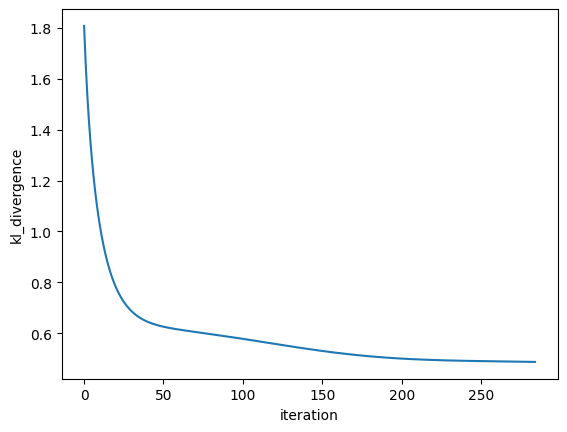

In [11]:
plt.plot([i for i in range(len(divergence_plot[15:]))], divergence_plot[15:])
plt.xlabel("iteration")
plt.ylabel("kl_divergence")
plt.show()


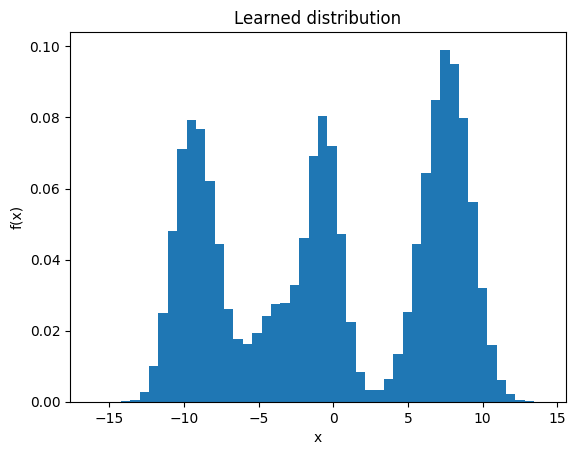

In [12]:
learned_mixture_index = np.random.choice(k, size = n, replace = True, p = predicted_weights_traditional)
learned_data = np.fromiter((np.random.normal(loc = predicted_mean_traditional[index], scale = np.sqrt([predicted_variance_traditional[index]])[0]) for index in learned_mixture_index), float)
assert data.shape == (n, )

plt.hist(learned_data, bins="auto", density=True)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Learned distribution")
plt.show()

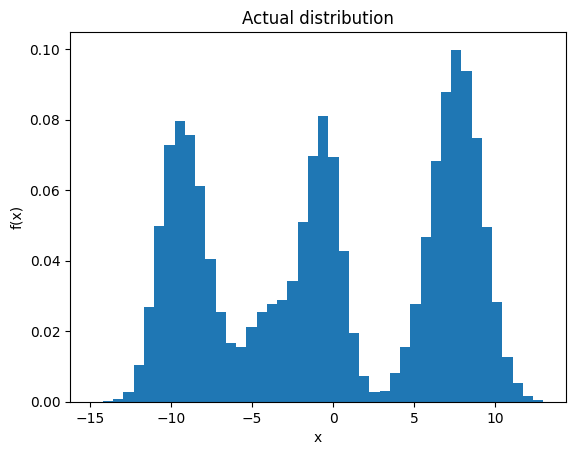

In [13]:
plt.hist(data, bins="auto", density=True)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Actual distribution")
plt.show()

# Dynamic-update EM

The traditional EM algorithm needs all the datapoint before making any changes to the weights, means and variances. From the idea of reinforcement learning, what if we update every time we see a datapoint (or a batch of datapoints)? In RL, dynamic programming value update will speed up the covergence rate significantly, and is proven to be an unbiased estimator of the actual value function. 

# 2a. Moving average method


In [14]:
predicted_mean_dynamic = np.random.uniform(low=-12.5, high=12.5, size=(k, ))
predicted_variance_dynamic = np.random.uniform(low=0.5, high=5, size=(k, ))
predicted_weights_dynamic = np.random.random(size=(k, ))
predicted_weights_dynamic = predicted_weights_dynamic / np.sum(predicted_weights_dynamic) 


batch_size = 10000
num_batch = n//batch_size
rng = np.random.default_rng()

print(num_batch)
def dynamicEM():
    global predicted_mean_dynamic, predicted_variance_dynamic, predicted_weights_dynamic, data
    divergence_plot = [] 
    counter = 0 
    
    KL_divergence = KL_div(predicted_mean_dynamic, predicted_variance_dynamic, predicted_weights_dynamic)
    print("kl div:", KL_divergence)
    prev_divergence = math.inf
    
    
    while counter < 300 and KL_divergence > 0:
        
        if counter % num_batch == 0:
            data = rng.permutation(data, axis = 0)
        
        """if counter < 10:
            batch_data = data
        else:"""
        if counter == 0:
            batch_data = data
        #counter % num_batch * batch_size
        batch_data = data[0 : (counter % num_batch + 1) * batch_size]
        
        
        probability_matrix = calculate_p_matrix(batch_data, predicted_mean_dynamic, predicted_variance_dynamic, predicted_weights_dynamic)
            # Normalise
        probability_matrix = probability_matrix / np.sum(probability_matrix, axis = 1, keepdims=True)
        
            
        normalised_p_matrix = probability_matrix / np.sum(probability_matrix, axis = 0, keepdims=True)
        
        if counter == 0:
            
                # Maximisation step
            predicted_weights_dynamic = (1/len(batch_data)) * np.sum(probability_matrix, axis = 0)
            
            mean_matrix = (batch_data * normalised_p_matrix.T).T
            predicted_mean_dynamic = np.sum(mean_matrix, axis = 0) 

            predicted_variance_dynamic = np.sum(np.multiply(np.power(np.tile(batch_data, (k, 1)).T - predicted_mean_dynamic, 2), normalised_p_matrix), axis = 0)
        else: #
            predicted_weights_dynamic = predicted_weights_dynamic + 2 *((1/len(batch_data)) * np.sum(probability_matrix, axis = 0) - predicted_weights_dynamic) / 3
            mean_matrix = (batch_data * normalised_p_matrix.T).T
            
            predicted_mean_dynamic = predicted_mean_dynamic + 2 *(np.sum(mean_matrix, axis = 0) - predicted_mean_dynamic) / 3
            #0.01 * 2 *(predicted_mean_dynamic - np.sum(mean_matrix, axis = 0))
            predicted_variance_dynamic = predicted_variance_dynamic + 2*(np.sum(np.multiply(np.power(np.tile(batch_data, (k, 1)).T - predicted_mean_dynamic, 2), normalised_p_matrix), axis = 0) - predicted_variance_dynamic) / 3
        
        diff = prev_divergence - KL_divergence
        prev_divergence = KL_divergence
        KL_divergence = KL_div(predicted_mean_dynamic, predicted_variance_dynamic, predicted_weights_dynamic)
        
        if counter % 15 == 0:
            print("kl div:", KL_divergence, " |  iter:", counter, " |  difference vs the prev iter:", diff)
            
        
        divergence_plot.append(KL_divergence)
        counter += 1
    return divergence_plot


10


In [15]:
divergence_plot = dynamicEM()


kl div: 2629.8509146779934
kl div: 237.5707308065504  |  iter: 0  |  difference vs the prev iter: inf
kl div: 8.29401217043856  |  iter: 15  |  difference vs the prev iter: 0.6641478803100931
kl div: 5.373784546953159  |  iter: 30  |  difference vs the prev iter: 0.27625236325627345
kl div: 1.6574633676369717  |  iter: 45  |  difference vs the prev iter: 0.09313522937901286
kl div: 2.6698078266829564  |  iter: 60  |  difference vs the prev iter: 0.0010904180120399065
kl div: 0.8447009167336083  |  iter: 75  |  difference vs the prev iter: 0.04819305949589214
kl div: 0.7770383749127353  |  iter: 90  |  difference vs the prev iter: 0.03909927517864953
kl div: 0.9811037585252735  |  iter: 105  |  difference vs the prev iter: 0.11251257352446964
kl div: 1.2665000595481302  |  iter: 120  |  difference vs the prev iter: 0.09209681978206874
kl div: 0.617712730749985  |  iter: 135  |  difference vs the prev iter: 0.1205668025622405
kl div: 1.1827418953714512  |  iter: 150  |  difference vs the

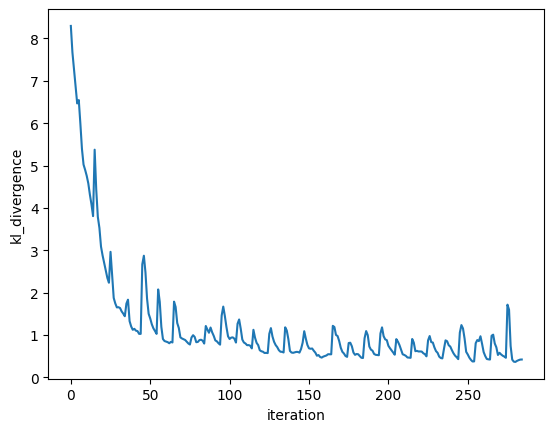

In [16]:
plt.plot([i for i in range(len(divergence_plot[15:]))], divergence_plot[15:])
plt.xlabel("iteration")
plt.ylabel("kl_divergence")
plt.show()


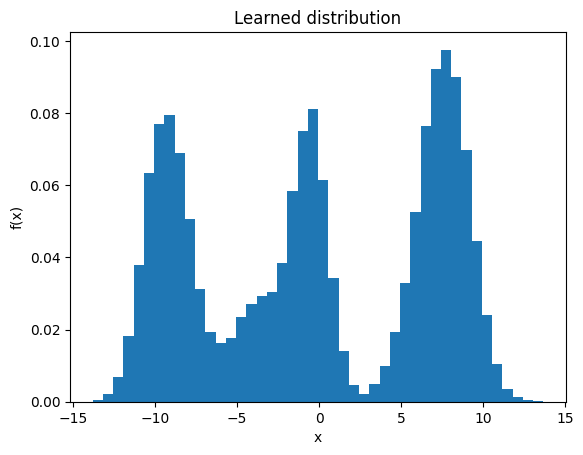

In [17]:
learned_mixture_index = np.random.choice(k, size = n, replace = True, p = predicted_weights_dynamic)
learned_data = np.fromiter((np.random.normal(loc = predicted_mean_dynamic[index], scale = np.sqrt([predicted_variance_dynamic[index]])[0]) for index in learned_mixture_index), float)
assert data.shape == (n, )

plt.hist(learned_data, bins="auto", density=True)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Learned distribution")
plt.show()

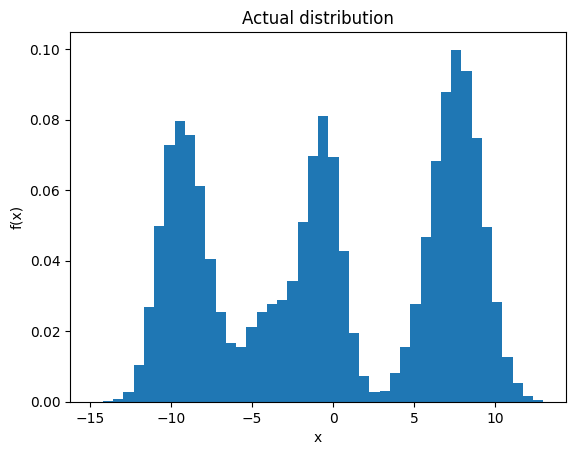

In [18]:
plt.hist(data, bins="auto", density=True)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Actual distribution")
plt.show()

# 2b Mini-batch algorithm

In [19]:
predicted_mean_dynamic = np.random.uniform(low=-12.5, high=12.5, size=(k, ))
predicted_variance_dynamic = np.random.uniform(low=0.5, high=5, size=(k, ))
predicted_weights_dynamic = np.random.random(size=(k, ))
predicted_weights_dynamic = predicted_weights_dynamic / np.sum(predicted_weights_dynamic) 


batch_size = 10000
num_batch = n//batch_size
rng = np.random.default_rng()

print(num_batch)
def dynamicEM():
    global predicted_mean_dynamic, predicted_variance_dynamic, predicted_weights_dynamic, data
    divergence_plot = [] 
    counter = 0 
    stepsize = (1 - 10 ** -10) * (counter + 1) ** (0.6)
    
    KL_divergence = KL_div(predicted_mean_dynamic, predicted_variance_dynamic, predicted_weights_dynamic)
    print("kl div:", KL_divergence)
    prev_divergence = math.inf
    
    
    while counter < 300 and KL_divergence > 0:
        
        if counter % num_batch == 0:
            data = rng.permutation(data, axis = 0)
        
        """if counter < 10:
            batch_data = data
        else:"""
        if counter == 0:
            batch_data = data
        #counter % num_batch * batch_size
        batch_data = data[0 : (counter % num_batch + 1) * batch_size]
        
        
        probability_matrix = calculate_p_matrix(batch_data, predicted_mean_dynamic, predicted_variance_dynamic, predicted_weights_dynamic)
            # Normalise
        probability_matrix = probability_matrix / np.sum(probability_matrix, axis = 1, keepdims=True)
        
            
        normalised_p_matrix = probability_matrix / np.sum(probability_matrix, axis = 0, keepdims=True)
        
        if counter == 0:
            
                # Maximisation step
            predicted_weights_dynamic = (1/len(batch_data)) * np.sum(probability_matrix, axis = 0)
            
            mean_matrix = (batch_data * normalised_p_matrix.T).T
            predicted_mean_dynamic = np.sum(mean_matrix, axis = 0) 

            predicted_variance_dynamic = np.sum(np.multiply(np.power(np.tile(batch_data, (k, 1)).T - predicted_mean_dynamic, 2), normalised_p_matrix), axis = 0)
        else: #
            predicted_weights_dynamic = predicted_weights_dynamic + stepsize * ((1/len(batch_data)) * np.sum(probability_matrix, axis = 0) - predicted_weights_dynamic)
            mean_matrix = (batch_data * normalised_p_matrix.T).T
            
            predicted_mean_dynamic = predicted_mean_dynamic + stepsize *(np.sum(mean_matrix, axis = 0) - predicted_mean_dynamic) 
            #0.01 * 2 *(predicted_mean_dynamic - np.sum(mean_matrix, axis = 0))
            predicted_variance_dynamic = predicted_variance_dynamic + stepsize *(np.sum(np.multiply(np.power(np.tile(batch_data, (k, 1)).T - predicted_mean_dynamic, 2), normalised_p_matrix), axis = 0) - predicted_variance_dynamic)
        
        diff = prev_divergence - KL_divergence
        prev_divergence = KL_divergence
        KL_divergence = KL_div(predicted_mean_dynamic, predicted_variance_dynamic, predicted_weights_dynamic)
        
        if counter % 15 == 0:
            print("kl div:", KL_divergence, " |  iter:", counter, " |  difference vs the prev iter:", diff)
            
        
        divergence_plot.append(KL_divergence)
        counter += 1
    return divergence_plot


10


In [20]:
divergence_plot = dynamicEM()

kl div: 1952.3333324311914
kl div: 137.47983032001792  |  iter: 0  |  difference vs the prev iter: inf
kl div: 3.3442711759026413  |  iter: 15  |  difference vs the prev iter: 0.38347889778547195
kl div: 3.0601739340935854  |  iter: 30  |  difference vs the prev iter: -0.006514899090257931
kl div: 2.241360046957484  |  iter: 45  |  difference vs the prev iter: -0.12893650995575667
kl div: 3.9881971535491014  |  iter: 60  |  difference vs the prev iter: -0.030498982140022335
kl div: 2.4090717222608373  |  iter: 75  |  difference vs the prev iter: 0.10768828549366782
kl div: 2.8527048681338805  |  iter: 90  |  difference vs the prev iter: 0.02318425187869022
kl div: 2.0846604096269847  |  iter: 105  |  difference vs the prev iter: 0.3845229844637865
kl div: 3.7328321250293377  |  iter: 120  |  difference vs the prev iter: -0.012695457689526402
kl div: 1.9569136747923663  |  iter: 135  |  difference vs the prev iter: -0.0693020531771249
kl div: 5.421750218646278  |  iter: 150  |  differen

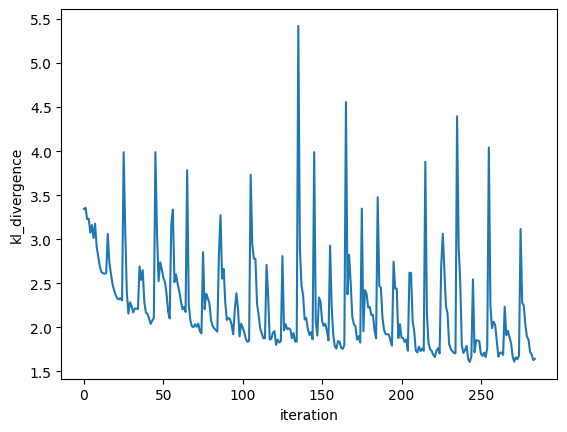

In [21]:
plt.plot([i for i in range(len(divergence_plot[15:]))], divergence_plot[15:])
plt.xlabel("iteration")
plt.ylabel("kl_divergence")
plt.show()


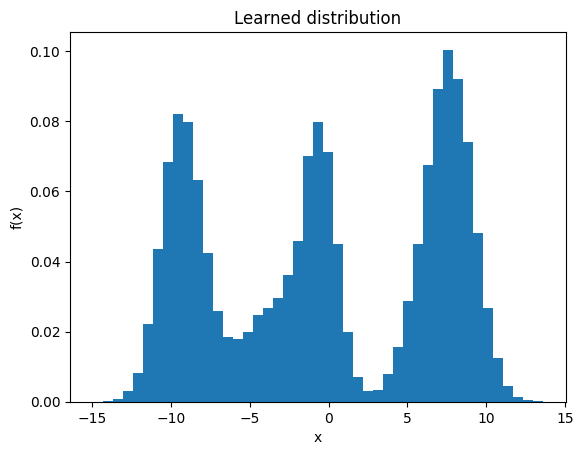

In [22]:
learned_mixture_index = np.random.choice(k, size = n, replace = True, p = predicted_weights_dynamic)
learned_data = np.fromiter((np.random.normal(loc = predicted_mean_dynamic[index], scale = np.sqrt([predicted_variance_dynamic[index]])[0]) for index in learned_mixture_index), float)
assert data.shape == (n, )

plt.hist(learned_data, bins="auto", density=True)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Learned distribution")
plt.show()

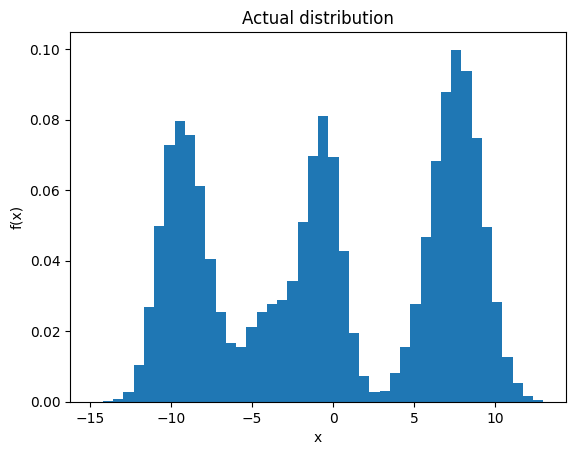

In [23]:
plt.hist(data, bins="auto", density=True)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Actual distribution")
plt.show()